In [1]:
''' 共分成5步：
1, 加载数据；
2，实例化xgb分类器对象，并训练模型；
3，预测；
4，网格调参；
5，XGBoost的核心思想。'''


from sklearn import datasets
import numpy as np
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1, 加载数据：
myDatas = datasets.load_iris()

X_train,X_test,y_train,y_test = train_test_split(  #划分训练集、测试集
    myDatas.data,myDatas.target,   #load_iris的原始数据集
    test_size = 0.3,
    random_state = 7
)

In [2]:
# 2，实例化xgb分类器对象，并训练模型：
clfXgb = XGBClassifier(n_estimators=10,max_depth=3,learning_rate=0.1)  #learning_rate = 0.1 根据经验是最合适的学习率，精确度0.93，改成0.5，精确度降为0.91了。
# 若将xgb用于回归，与分类类似，只需实例化模型：rXgb = XGBRegressor(n_estimators=10,max_depth=3)
clfXgb.fit(X_train,y_train)   #训练分类

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [3]:
# 3，预测
clfXgbPred = clfXgb.predict(X_test)

acc = accuracy_score(y_test,clfXgbPred)   #评估得分

print("预测精确度：",acc)

预测精确度： 0.9333333333333333


In [4]:
# 4，网格调参：
#模型建好以后要选一些合适的参数，让模型最优（损失最小）才是目的，
#然后把这些参数应用到模型，重新建模保存，服务于更多任务的测试工作==
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


myMode = XGBClassifier()#正常这里是不会人为揸定参数，要求最合适参数，上面实例只是根据经验传了固定参数展示分类实现，
#以学习率为例，找一个最合适的学习率
#设几个不同学习率的列表，后面来遍历它，看哪个学习率下分类精确度最高，就用哪个学习率代回模型重新建模
learning_rate=[0.0001,0.001,0.1,0.2,0.3]
#这次使用交叉验证（交替充份使用有限数据）划分数据集
#实例化交叉验证类
kfold = StratifiedKFold(n_splits=2,shuffle=True,random_state=7)
#n_splits分成几组测试验证对
#实例化网格调参类（传入交叉验实例对象及XGB分类对象）
grid_search = GridSearchCV(myMode,#传入XGB分类对象
                           dict(learning_rate=learning_rate),#这里要字典格式打包传参
                           scoring = 'neg_log_loss',#评估损失函数选择
                           n_jobs = 1,#当前所有空闲CPU都去跑这个模型
                           cv = kfold#指定交叉验证实例对象
                          )
#用最终结合好的对象fit原始数据即可自动完成交叉验证并调参
gridRs = grid_search.fit(myDatas.data,myDatas.target)

#打印最优学习率和其得分
print("最优学习率: %s ，得分：%f " % (gridRs.best_params_,gridRs.best_score_))
means = gridRs.cv_results_['mean_test_score']
params = gridRs.cv_results_['params']
#打印平均分
print("每次迭代的平均值：",means)
print("对应的本次迭代学习率参数：",params)

'''
#以上调参完即可确定最优的learning_rate在模型中使用了，代回去再次建模，
#才可得到开篇中的最精确的预测值。
#试下把开篇learning_rate = 0.1 改成0.5，精确度从0.93降为0.91了。
#此模型才可用于其它同类任务的预测工作，总的流程是这样的。
#此处只调了一个参数举例，其它参数必要时也要调
'''

最优学习率: {'learning_rate': 0.1} ，得分：-0.169467 
每次迭代的平均值： [-1.08640095 -0.98505858 -0.169467   -0.18732891 -0.18775922]
对应的本次迭代学习率参数： [{'learning_rate': 0.0001}, {'learning_rate': 0.001}, {'learning_rate': 0.1}, {'learning_rate': 0.2}, {'learning_rate': 0.3}]


'\n#以上调参完即可确定最优的learning_rate在模型中使用了，代回去再次建模，\n#才可得到开篇中的最精确的预测值。\n#试下把开篇learning_rate = 0.1 改成0.5，精确度从0.93降为0.91了。\n#此模型才可用于其它同类任务的预测工作，总的流程是这样的。\n#此处只调了一个参数举例，其它参数必要时也要调\n'

[0]	validation_0-mlogloss:0.98021
Will train until validation_0-mlogloss hasn't improved in 3 rounds.
[1]	validation_0-mlogloss:0.881483
[2]	validation_0-mlogloss:0.798046
[3]	validation_0-mlogloss:0.72683
[4]	validation_0-mlogloss:0.665589
[5]	validation_0-mlogloss:0.612621
[6]	validation_0-mlogloss:0.566605
[7]	validation_0-mlogloss:0.52649
[8]	validation_0-mlogloss:0.491428
[9]	validation_0-mlogloss:0.460721

预测精确度: 0.9333333333333333


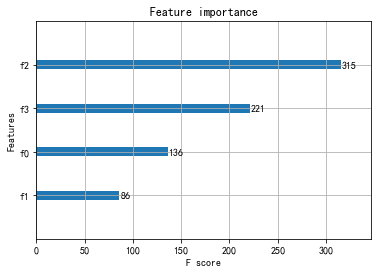

In [6]:
# 5，XGBoost的核心思想
# 下面通过每一步的test预测值，看是否XGBoost每加一棵树都会让集成学习效果优化提升(这是XGBoost的核心思想)。
eval_set = [(X_test,y_test)]   # 构造一个测试集

clfXgb.fit(X_train,y_train,early_stopping_rounds=3,
           eval_metric='mlogloss',eval_set = eval_set,verbose = True)
#参数：模型饱和后再加3次停止该模型
#指定mlogloss为损失函数，用来做模型优化标准，使logloss最小。
#测试值
clfXgbPred_2 = clfXgb.predict(X_test)
#把预测值装进预测值列表
predictions = [round(v) for v in clfXgbPred_2]
#遍历预测结果评估
acc_2 = accuracy_score(y_test,predictions)#每个测试结果和它对应的所有预测值比较分别评估

print("\n预测精确度:",acc_2)
#由结果可见XGB的确是在每步加入新村时使得集成学习向优化提升（损失越来越小，预测越来越接近真实值）
#另外上面设了early_stopping_rounds 为3 说明从底下往上数3个0.56时模型就已经是饱和状态了。


#==下面看一个xgboost的功能
#plot_importantce，
#可以查看特征重要性==
from xgboost import plot_importance
from matplotlib import pyplot
%matplotlib inline

model = XGBClassifier()   #实例化分类器对象
model.fit(myDatas.data,myDatas.target)   #对象fit传原始数据集即可
rs = plot_importance(model)   #算特征重要性
pyplot.show(rs)   # 可视化
#图上列出了4个特征重要性